Python建模库介绍

* statsmodels

* scikit-learn

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_note_interactivity = "all"
%matplotlib inline


import os
import sys
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

1. pandas与建模代码的结合

使用pandas进行数据的载入和清洗，之后再切换到模型库去建立模型是一种常见的模型开发工具流。

*特征工程*是机器学习中模型开发的重要部分之一。特征工程：指从原生数据集中提取可用于模型上下文的有效信息的数据转换过程或分析。

本章节的作用是提供一些范例利用pandas进行数据操作和建模之间的无痛切换方法

pandas和其他分析库的结合点通常是NumPy数组。要将dataframe对象转换为numpy数组，使用.value属性。

In [2]:
data = pd.DataFrame({
    'x0': [1, 2, 3, 4, 5],
    'x1': [0.01, -0.01, 0.25, -4.1, 0.],
    'y': [-1.5, 0., 3.6, 1.3, -2.]})

In [3]:
data

,x0,x1,y
0,1,0.01,-1.5
1,2,-0.01,0.0
2,3,0.25,3.6
3,4,-4.10,1.3
4,5,0.00,-2.0


In [4]:
data.columns

Index(['x0', 'x1', 'y'], dtype='object')

In [5]:
df2 = pd.DataFrame(data.values, columns=['one', 'two', 'three'])

In [6]:
df2

,one,two,three
0,1.0,0.01,-1.5
1,2.0,-0.01,0.0
2,3.0,0.25,3.6
3,4.0,-4.10,1.3
4,5.0,0.00,-2.0


.values属性一般是在数据是同构化的时候使用。如果是异构化的，结果将是Python对象的ndarray

In [7]:
df3 = data.copy()
df3['strings'] = list('abcde')

In [8]:
df3

,x0,x1,y,strings
0,1,0.01,-1.5,a
1,2,-0.01,0.0,b
2,3,0.25,3.6,c
3,4,-4.10,1.3,d
4,5,0.00,-2.0,e


In [9]:
df3.values, type(df3.values)

(array([[1, 0.01, -1.5, 'a'],
        [2, -0.01, 0.0, 'b'],
        [3, 0.25, 3.6, 'c'],
        [4, -4.1, 1.3, 'd'],
        [5, 0.0, -2.0, 'e']], dtype=object), numpy.ndarray)

In [10]:
data.values, type(data.values)

(array([[ 1.  ,  0.01, -1.5 ],
        [ 2.  , -0.01,  0.  ],
        [ 3.  ,  0.25,  3.6 ],
        [ 4.  , -4.1 ,  1.3 ],
        [ 5.  ,  0.  , -2.  ]]), numpy.ndarray)

In [11]:
model_cols = ['x0', 'x1']
data.loc[:, model_cols].values

array([[ 1.  ,  0.01],
       [ 2.  , -0.01],
       [ 3.  ,  0.25],
       [ 4.  , -4.1 ],
       [ 5.  ,  0.  ]])

In [12]:
data['category'] = pd.Categorical(list('abaab')
                                 , categories=['a', 'b'])

In [13]:
data

,x0,x1,y,category
0,1,0.01,-1.5,a
1,2,-0.01,0.0,b
2,3,0.25,3.6,a
3,4,-4.10,1.3,a
4,5,0.00,-2.0,b


In [14]:
# 想用虚拟变量来替代category列，先创建虚拟变量，然后删除掉category列，最后连接结果

dummies = pd.get_dummies(data.category, prefix='category')
data_with_dummies = data.drop('category', axis=1).join(dummies)
data_with_dummies

,x0,x1,y,category_a,category_b
0,1,0.01,-1.5,1,0
1,2,-0.01,0.0,0,1
2,3,0.25,3.6,1,0
3,4,-4.10,1.3,1,0
4,5,0.00,-2.0,0,1


2. 使用Patsy创建模型描述

patsy.readthedocs.io

Patsy使用一个用于描述统计模型（尤其是线性模型）的Python库。它使用一种小型基于字符串的公式语法。

Patsy能够很好的支持statsmodels中特定的线性模型

例如： y  ~  x0  +  x1

In [15]:
import patsy

In [16]:
data = pd.DataFrame({'x0': [1, 2, 3, 4, 5],
                     'x1': [0.01, -0.01, 0.25, -4.1, 0.],
                     'y': [-1.5, 0., 3.6, 1.3, -2.]})

In [17]:
y, X = patsy.dmatrices('y ~ x0 + x1', data)

In [18]:
y

DesignMatrix with shape (5, 1)
     y
  -1.5
   0.0
   3.6
   1.3
  -2.0
  Terms:
    'y' (column 0)

In [19]:
X

DesignMatrix with shape (5, 3)
  Intercept  x0     x1
          1   1   0.01
          1   2  -0.01
          1   3   0.25
          1   4  -4.10
          1   5   0.00
  Terms:
    'Intercept' (column 0)
    'x0' (column 1)
    'x1' (column 2)

这些Patsy的DesignMatrix实例是含有附加元数据的Numpy ndarray：

In [20]:
np.asarray(y)

array([[-1.5],
       [ 0. ],
       [ 3.6],
       [ 1.3],
       [-2. ]])

In [21]:
np.asarray(X)

array([[ 1.  ,  1.  ,  0.01],
       [ 1.  ,  2.  , -0.01],
       [ 1.  ,  3.  ,  0.25],
       [ 1.  ,  4.  , -4.1 ],
       [ 1.  ,  5.  ,  0.  ]])

In [22]:
# 在OLS线性回归中引入截距项
# 0零在公式中的意思是截距项intercept值为0，在这里仅做占位
patsy.dmatrices('y ~ x0 + x1 + 0', data)[1]

DesignMatrix with shape (5, 2)
  x0     x1
   1   0.01
   2  -0.01
   3   0.25
   4  -4.10
   5   0.00
  Terms:
    'x0' (column 0)
    'x1' (column 1)

Patsy对象可以直接传递给其它的一些模块，例如numpy.linalg.lstsq等。

In [23]:
coef, resid, _, _=np.linalg.lstsq(X, y)

C:\Program Files\Python35\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


In [24]:
coef

array([[ 0.31290976],
       [-0.07910564],
       [-0.26546384]])

In [25]:
help(np.linalg.lstsq)

Help on function lstsq in module numpy.linalg.linalg:

lstsq(a, b, rcond='warn')
    Return the least-squares solution to a linear matrix equation.
    
    Solves the equation `a x = b` by computing a vector `x` that
    minimizes the Euclidean 2-norm `|| b - a x ||^2`.  The equation may
    be under-, well-, or over- determined (i.e., the number of
    linearly independent rows of `a` can be less than, equal to, or
    greater than its number of linearly independent columns).  If `a`
    is square and of full rank, then `x` (but for round-off error) is
    the "exact" solution of the equation.
    
    Parameters
    ----------
    a : (M, N) array_like
        "Coefficient" matrix.
    b : {(M,), (M, K)} array_like
        Ordinate or "dependent variable" values. If `b` is two-dimensional,
        the least-squares solution is calculated for each of the `K` columns
        of `b`.
    rcond : float, optional
        Cut-off ratio for small singular values of `a`.
        For the pur

ValueError: operands could not be broadcast together with shapes (5,3) (3,1) 

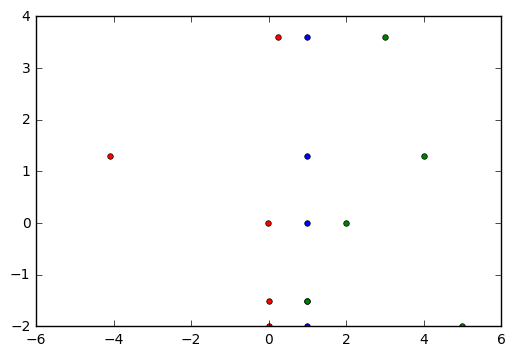

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(X, y, 'o', markersize=4)
ax.plot(X, X * coef)
plt.legend()

In [27]:
coef = pd.Series(coef.squeeze(), index=X.design_info.column_names) #元数据在design_info中

In [28]:
coef, coef.squeeze()

(Intercept    0.312910
 x0          -0.079106
 x1          -0.265464
 dtype: float64, Intercept    0.312910
 x0          -0.079106
 x1          -0.265464
 dtype: float64)

In [29]:
y, X = patsy.dmatrices('y ~ x0 + np.log(np.abs(x1) + 1)', data)
X

DesignMatrix with shape (5, 3)
  Intercept  x0  np.log(np.abs(x1) + 1)
          1   1                 0.00995
          1   2                 0.00995
          1   3                 0.22314
          1   4                 1.62924
          1   5                 0.00000
  Terms:
    'Intercept' (column 0)
    'x0' (column 1)
    'np.log(np.abs(x1) + 1)' (column 2)

2.1 Patsy公式中的数据转换

In [30]:
y, X = patsy.dmatrices('y ~ x0 + np.log(np.abs(x1) + 1)', data)
X

DesignMatrix with shape (5, 3)
  Intercept  x0  np.log(np.abs(x1) + 1)
          1   1                 0.00995
          1   2                 0.00995
          1   3                 0.22314
          1   4                 1.62924
          1   5                 0.00000
  Terms:
    'Intercept' (column 0)
    'x0' (column 1)
    'np.log(np.abs(x1) + 1)' (column 2)

In [31]:
# 一些常用的变量转换包括标准化（均值0和方差1）和居中（减去平均值）。

In [32]:
y, X = patsy.dmatrices('y ~ standardize(x0) + center(x1)', data)
X

DesignMatrix with shape (5, 3)
  Intercept  standardize(x0)  center(x1)
          1         -1.41421        0.78
          1         -0.70711        0.76
          1          0.00000        1.02
          1          0.70711       -3.33
          1          1.41421        0.77
  Terms:
    'Intercept' (column 0)
    'standardize(x0)' (column 1)
    'center(x1)' (column 2)

In [33]:
# patsy.build_design_matrices函数可以使用原始样本内数据集中保存的信息变换应用于新的样本外数据上

In [34]:
new_data = pd.DataFrame({
        'x0': [7, 7, 8, 9],
        'x1': [3.1, -0.5, 0, 2.3],
        'y': [1, 2, 3, 4]})

In [35]:
new_X = patsy.build_design_matrices([X.design_info], new_data)
new_X

[DesignMatrix with shape (4, 3)
   Intercept  standardize(x0)  center(x1)
           1          2.82843        3.87
           1          2.82843        0.27
           1          3.53553        0.77
           1          4.24264        3.07
   Terms:
     'Intercept' (column 0)
     'standardize(x0)' (column 1)
     'center(x1)' (column 2)]

'+'在Patsy公式的上下文中并不是加法的意思。

In [36]:
y, X = patsy.dmatrices('y ~ I(x0 + x1)', data)
X

DesignMatrix with shape (5, 2)
  Intercept  I(x0 + x1)
          1        1.01
          1        1.99
          1        3.25
          1       -0.10
          1        5.00
  Terms:
    'Intercept' (column 0)
    'I(x0 + x1)' (column 1)

2.2 分类数据与Patsy

In [37]:
data = pd.DataFrame({
    'key1': ['a', 'a', 'b', 'b', 'a', 'b', 'a', 'b'],
    'key2': [0, 1, 0, 1, 0, 1, 0, 0],
    'v1': [1, 2, 3, 4, 5, 6, 7, 8],
    'v2': [-1, 0, 2.5, -0.5, 4.0, -1.2, 0.2, -1.7]
})

In [38]:
y, X = patsy.dmatrices('v2 ~ key1', data)
X

DesignMatrix with shape (8, 2)
  Intercept  key1[T.b]
          1          0
          1          0
          1          1
          1          1
          1          0
          1          1
          1          0
          1          1
  Terms:
    'Intercept' (column 0)
    'key1' (column 1)

In [39]:
# 如果忽略了模型的截距，每个类别值的列将会被包含在模型的设计矩阵中；否则会删掉一列虚拟变量，防止共线性

In [40]:
y, X = patsy.dmatrices('v2 ~ key1 + 0', data)
X

DesignMatrix with shape (8, 2)
  key1[a]  key1[b]
        1        0
        1        0
        0        1
        0        1
        1        0
        0        1
        1        0
        0        1
  Terms:
    'key1' (columns 0:2)

In [41]:
# 数字类型列可以使用C函数解释为分类类型：

y, X = patsy.dmatrices('v2 ~ C(key2)', data)
X

DesignMatrix with shape (8, 2)
  Intercept  C(key2)[T.1]
          1             0
          1             1
          1             0
          1             1
          1             0
          1             1
          1             0
          1             0
  Terms:
    'Intercept' (column 0)
    'C(key2)' (column 1)

In [42]:
# 当在模型中使用多个分类名词列时，事情会变得稍微复杂。可以使用形式为可以key1:key2的交互项，例如，可用于方差分析（ANOVA）模型

In [43]:
data['key2'] = data['key2'].map({0: 'zero', 1: 'one'})
data

,key1,key2,v1,v2
0,a,zero,1,-1.0
1,a,one,2,0.0
2,b,zero,3,2.5
3,b,one,4,-0.5
4,a,zero,5,4.0
5,b,one,6,-1.2
6,a,zero,7,0.2
7,b,zero,8,-1.7


In [44]:
y, X = patsy.dmatrices('v2 ~ key1 + key2', data)
X

DesignMatrix with shape (8, 3)
  Intercept  key1[T.b]  key2[T.zero]
          1          0             1
          1          0             0
          1          1             1
          1          1             0
          1          0             1
          1          1             0
          1          0             1
          1          1             1
  Terms:
    'Intercept' (column 0)
    'key1' (column 1)
    'key2' (column 2)

In [45]:
y, X = patsy.dmatrices('v2 ~ key1 + key2 + key1:key2', data)
X

DesignMatrix with shape (8, 4)
  Intercept  key1[T.b]  key2[T.zero]  key1[T.b]:key2[T.zero]
          1          0             1                       0
          1          0             0                       0
          1          1             1                       1
          1          1             0                       0
          1          0             1                       0
          1          1             0                       0
          1          0             1                       0
          1          1             1                       1
  Terms:
    'Intercept' (column 0)
    'key1' (column 1)
    'key2' (column 2)
    'key1:key2' (column 3)

3. statsmodels介绍

statsmodels是一个Python库，用于拟合多种统计模型，执行统计测试以及数据探索和可视化。statsmodels包含更多的“经典”频率学派统计方法，而贝叶斯方法和机器学习模型可在其它库中找到。

主要模型：

* 线性模型，广义线性模型和鲁棒线性模型

* 线性混合效应模型

* 方差分析（ANOVA）方法

* 时间序列过程和状态空间模型

* 广义的矩量法

In [46]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [47]:
def dnorm(mean, variance, size=1):
  if isinstance(size, int):
    size = size,
  return mean + np.sqrt(variance) + np.random.randn(*size)

In [48]:
np.random.seed(12345)
N = 100
X = np.c_[dnorm(0, 0.4, size=N),
          dnorm(0, 0.6, size=N),
          dnorm(0, 0.2, size=N)]
eps = dnorm(0, 0.1, size=N)
beta = [0.1, 0.3, 0.5]
y = np.dot(X, beta) + eps

dnorm是用于生成具有特定均值和方差的正态分布数据的辅助函数

In [49]:
X[:5]

array([[ 0.42774787, -0.79106062,  1.5746947 ],
       [ 1.11139887,  0.21205648, -0.12114985],
       [ 0.11301682,  0.74193253,  0.75657576],
       [ 0.07672523, -0.15440953, -0.13017188],
       [ 2.5982361 ,  0.29202402, -0.72142048]])

In [50]:
y[:5]

array([ 2.65626531, -0.97983647,  0.55015556, -0.13332918,  0.68301081])

In [51]:
# 添加截距项
X_model = sm.add_constant(X)
X_model[:5]

array([[ 1.        ,  0.42774787, -0.79106062,  1.5746947 ],
       [ 1.        ,  1.11139887,  0.21205648, -0.12114985],
       [ 1.        ,  0.11301682,  0.74193253,  0.75657576],
       [ 1.        ,  0.07672523, -0.15440953, -0.13017188],
       [ 1.        ,  2.5982361 ,  0.29202402, -0.72142048]])

In [52]:
# sm.OLS类可以拟合一个最小二乘回归
model = sm.OLS(y, X)

In [53]:
# 模型fit方法反回了一个回归结果对象，该对象包括了估计的模型参数和其他诊断：

results = model.fit()

results.params

array([0.39004368, 0.29561838, 0.5841267 ])

In [54]:
# 在results上调用summary方法可以打印出模型的诊断细节：

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     25.14
Date:                Tue, 07 May 2019   Prob (F-statistic):           4.05e-12
Time:                        21:16:26   Log-Likelihood:                -153.12
No. Observations:                 100   AIC:                             312.2
Df Residuals:                      97   BIC:                             320.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3900      0.098      3.969      0.0

In [55]:
data = pd.DataFrame(X, columns=['col0', 'col1', 'col2'])
data['y'] = y
data[:5]

,col0,col1,col2,y
0,0.427748,-0.791061,1.574695,2.656265
1,1.111399,0.212056,-0.121150,-0.979836
2,0.113017,0.741933,0.756576,0.550156
3,0.076725,-0.154410,-0.130172,-0.133329
4,2.598236,0.292024,-0.721420,0.683011


In [56]:
# 使用statsmodels公式API和Patsy公式字符串
# 在模型中不指定+Intercept

results = smf.ols('y ~ col0 + col1 + col2', data=data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     9.360
Date:                Tue, 07 May 2019   Prob (F-statistic):           1.74e-05
Time:                        21:16:26   Log-Likelihood:                -148.96
No. Observations:                 100   AIC:                             305.9
Df Residuals:                      96   BIC:                             316.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4593      0.159      2.883      0.0

In [57]:
# 根据新的样本外数据，以及建立的模型来计算预测值：

results.predict(data[:5])

0    1.295885
1    0.701156
2    0.967903
3    0.392951
4    0.772840
dtype: float64

3.2 评估时间序列处理

statsmodels中的另一类模型用于时间序列分析。其中包括自回归过程，卡尔曼滤波和其他状态空间模型，以及多变量自回归模型。

In [58]:
#一组带有自回归结构和噪声的时间序列数据

init_x= 4
import random
values  = [init_x, init_x]

b0 = 0.8
b1 = -0.4
noise = dnorm(0, 0.1, N)
for i in range(N):
    new_x = values[-1] * b0 + values[-2] * b1 + noise[i]
    values.append(new_x)

该数据具有参数0.8和-0.4的AR(2)结构（两个滞后）。当我们拟合一个AR模型时，可能不清楚包含的滞后项的数量，因此可以用更大的滞后数量来拟合该模型。

In [59]:
MAXLAGS = 5
model = sm.tsa.AR(values)
results = model.fit(MAXLAGS)


In [60]:
# 估计截距和两个滞后的估计
results.params

array([ 0.22869364,  0.92661709, -0.49175515,  0.11296018, -0.13122752,
        0.13839466])

4. scikit-learn 介绍

scikit-learn是使用最广泛且最受信任的通用Python机器学习库。它包含广泛的标准监督和无监督的机器学习方法，包括用于模型选择和评估、数据转换、加载和模型持久化的工具。这些模型可以用于分类、聚类、预测和其他常见任务。

In [61]:
os.chdir('E:/py_pandasDA_practice/')

In [62]:
train = pd.read_csv('code/datasets/titanic/train.csv')
test = pd.read_csv('code/datasets/titanic/test.csv')

In [63]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [64]:
train[:4]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S


In [65]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [66]:
impute_value = train['Age'].median()
train['Age'] = train['Age'].fillna(impute_value)
test['Age'] = test['Age'].fillna(impute_value)

In [67]:
train['IsFemale'] = (train['Sex'] == 'female').astype(int)
test['IsFemale'] = (test['Sex'] == 'female').astype(int)

In [68]:
predictors = ['Pclass', 'IsFemale', 'Age']
X_train = train[predictors].values
X_test = test[predictors].values
y_train = train['Survived'].values

X_train[:5]

array([[ 3.,  0., 22.],
       [ 1.,  1., 38.],
       [ 3.,  1., 26.],
       [ 1.,  1., 35.],
       [ 3.,  0., 35.]])

In [69]:
y_train[:5]

array([0, 1, 1, 1, 0], dtype=int64)

In [70]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

In [71]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [72]:
y_predict = model.predict(X_test)

In [73]:
y_predict[:10]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0], dtype=int64)

In [74]:
#(y_true == y_predict).mean()

In [75]:
from sklearn.linear_model import LogisticRegressionCV

In [76]:
# 这个参数C代表网络搜索在模型正则化参数C上的细致度

model_cv = LogisticRegressionCV(10)
model_cv.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [77]:
# 交叉验证

from sklearn.model_selection import cross_val_score

In [78]:
model = LogisticRegression(C=10)

In [79]:
# 利用训练好的模型与训练数据的四个非重叠分割进行交叉验证

scores = cross_val_score(model, X_train, y_train, cv=4)

In [80]:
scores

array([0.77232143, 0.80269058, 0.77027027, 0.78828829])

Sex
female    28.716738
male      27.382294
Name: Age, dtype: float64 <class 'pandas.core.series.Series'>


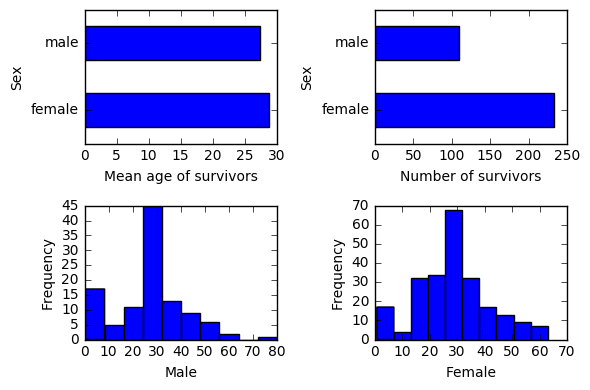

In [81]:
# 泰坦尼克号上不同性别幸存者的年龄均值

fig1 = plt.figure()
ax1 = fig1.add_subplot(2, 2, 1)
ax2 = fig1.add_subplot(2, 2, 2)
ax3 = fig1.add_subplot(2, 2, 3)
ax4 = fig1.add_subplot(2, 2, 4)

train_sur = train[train.Survived == 1] 
re_sex = train_sur.groupby('Sex').mean()['Age']
print(re_sex.head(5), type(re_sex))
re_sex.plot(ax=ax1, kind='barh')
ax1.set_xlabel('Mean age of survivors')

# 不同性别幸存人数

re_num = train_sur.groupby('Sex').count()
re_num['Name'].plot(ax=ax2, kind='barh')
ax2.set_xlabel('Number of survivors')

train_sur[train_sur.Sex == 'male'].Age.plot(ax=ax3, kind='hist', bins=10)
ax3.set_xlabel('Male')

train_sur[train_sur.Sex == 'female'].Age.plot(ax=ax4, kind='hist', bins=10)
ax4.set_xlabel('Female')

plt.tight_layout()